# Testing Logit Graph Fixes on Connectome Data

This notebook validates the four fixes applied to the `logit-graph` package:

1. **1.1 — Parameter pass-through**: Estimated `beta` is now passed to `GraphModel` (not just `sigma`).
2. **1.2 — Symmetric edge probability**: `P(edge i,j) = logistic(sigma + beta * (S_i + S_j))` is symmetric.
3. **1.4 — Spectral density resolution**: GIC histogram bins increased from 10 to 50.
4. **1.5 — Degree feature BFS**: `degree_vertex(d>=2)` now collects all hops, not just the frontier.

We test on two connectome datasets of different sizes.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '../../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

from logit_graph.simulation import (
    LogitGraphFitter,
    LogitGraphSimulation,
    GraphModelComparator,
    calculate_graph_attributes,
    estimate_sigma_only,
)
from logit_graph.degrees_counts import degree_vertex, get_sum_degrees
from logit_graph.logit_estimator import LogitRegEstimator
from logit_graph.gic import GraphInformationCriterion
from logit_graph.graph import GraphModel

sns.set_style('whitegrid')
plt.rcParams.update({'figure.figsize': (14, 5), 'font.size': 11})

print('Imports OK')

Imports OK


## 1. Load connectome data

In [3]:
DATA_DIR = '../../data/connectomes/'

# Small graph (29 nodes) — fast iteration
G_small = nx.read_graphml(DATA_DIR + 'mouse_visual.cortex_1.graphml').to_undirected()
# Medium graph (65 nodes)
G_medium = nx.read_graphml(DATA_DIR + 'mixed.species_brain_1.graphml').to_undirected()

for name, G in [('mouse_visual.cortex_1 (small)', G_small), ('mixed.species_brain_1 (medium)', G_medium)]:
    attrs = calculate_graph_attributes(G)
    print(f'\n{name}')
    for k, v in attrs.items():
        print(f'  {k}: {v}')


mouse_visual.cortex_1 (small)
  nodes: 29
  edges: 44
  density: 0.10837438423645321
  avg_clustering: 0.04942528735632184
  assortativity: -0.4708960803161381
  num_components: 1
  largest_component_size: 29
  avg_path_length: 2.9408866995073892
  diameter: 6

mixed.species_brain_1 (medium)
  nodes: 65
  edges: 730
  density: 0.35096153846153844
  avg_clustering: 0.6613661608142224
  assortativity: -0.025391337049728954
  num_components: 1
  largest_component_size: 65
  avg_path_length: 1.6995192307692308
  diameter: 3


---
## 2. Validate Fix 1.5 — `degree_vertex` BFS includes all hops

For d >= 2, the old code only returned degrees at **exactly** distance d. The fix
now returns degrees of all nodes within distance 1..d.

In [4]:
# Build a known path graph: 0 -- 1 -- 2 -- 3 -- 4
path_adj = np.zeros((5, 5))
for i, j in [(0,1), (1,2), (2,3), (3,4)]:
    path_adj[i, j] = path_adj[j, i] = 1

print('Path graph degrees: node0=1, node1=2, node2=2, node3=2, node4=1')
print()

for d in range(4):
    dv = degree_vertex(path_adj, vertex=0, d=d)
    print(f'd={d}: degree_vertex(0) = {dv}  (sum = {sum(dv)})')

print()
print('Expected for d=2 from vertex 0:')
print('  [deg(0), deg(1), deg(2)] = [1, 2, 2]  (includes hops 1 AND 2)')
print()

# Verify on actual connectome
adj_small = nx.to_numpy_array(G_small)
for d in range(4):
    vals = degree_vertex(adj_small, vertex=0, d=d)
    print(f'Connectome vertex 0, d={d}: {len(vals)} nodes in neighbourhood, sum_degrees={sum(vals)}')

Path graph degrees: node0=1, node1=2, node2=2, node3=2, node4=1

d=0: degree_vertex(0) = [np.float64(1.0)]  (sum = 1.0)
d=1: degree_vertex(0) = [np.float64(1.0), np.float64(2.0)]  (sum = 3.0)
d=2: degree_vertex(0) = [np.float64(1.0), np.float64(2.0), np.float64(2.0)]  (sum = 5.0)
d=3: degree_vertex(0) = [np.float64(1.0), np.float64(2.0), np.float64(2.0), np.float64(2.0)]  (sum = 7.0)

Expected for d=2 from vertex 0:
  [deg(0), deg(1), deg(2)] = [1, 2, 2]  (includes hops 1 AND 2)

Connectome vertex 0, d=0: 1 nodes in neighbourhood, sum_degrees=3.0
Connectome vertex 0, d=1: 4 nodes in neighbourhood, sum_degrees=36.0
Connectome vertex 0, d=2: 11 nodes in neighbourhood, sum_degrees=57.0
Connectome vertex 0, d=3: 13 nodes in neighbourhood, sum_degrees=76.0


---
## 3. Validate Fix 1.2 — Symmetric edge probability

The generation formula is now `sigma + beta * (S_i + S_j)`, which is symmetric
by construction. We verify by checking that swapping i,j produces identical logit values.

In [5]:
from scipy.special import expit

adj = nx.to_numpy_array(G_small)
n = adj.shape[0]
sigma_test, beta_test = -3.0, 0.05

asymmetry_count = 0
max_diff = 0.0
n_pairs_checked = 0

for d in [0, 1, 2]:
    for i in range(n):
        for j in range(i + 1, n):
            s_i = get_sum_degrees(adj, vertex=i, d=d)
            s_j = get_sum_degrees(adj, vertex=j, d=d)
            # New symmetric formula
            logit_ij = sigma_test + beta_test * (s_i + s_j)
            logit_ji = sigma_test + beta_test * (s_j + s_i)
            diff = abs(logit_ij - logit_ji)
            max_diff = max(max_diff, diff)
            if diff > 1e-12:
                asymmetry_count += 1
            n_pairs_checked += 1

print(f'Pairs checked: {n_pairs_checked}')
print(f'Asymmetric pairs: {asymmetry_count}')
print(f'Max |logit(i,j) - logit(j,i)|: {max_diff:.2e}')
print()
print('PASS: Edge probability is perfectly symmetric.' if asymmetry_count == 0 else 'FAIL: Asymmetry detected!')

Pairs checked: 1218
Asymmetric pairs: 0
Max |logit(i,j) - logit(j,i)|: 0.00e+00

PASS: Edge probability is perfectly symmetric.


---
## 4. Validate Fix 1.1 — Estimated beta is passed to generation

The logistic regression now estimates `[sigma, beta]` (2 params) from symmetric
features `(S_i + S_j)`, and both are passed to `GraphModel`.

In [6]:
adj_medium = nx.to_numpy_array(G_medium)

print('=== Parameter Estimation ===')
print()

for d in [0, 1, 2]:
    est = LogitRegEstimator(adj_medium, d=d, verbose=False)
    features, labels = est.get_features_labels()
    result, params, _ = est.estimate_parameters(l1_wt=1, alpha=0, features=features, labels=labels)
    
    print(f'd={d}:')
    print(f'  Feature matrix shape: {features.shape}  (should be [n_samples, 2])')
    print(f'  Number of params: {len(params)}  (should be 2: sigma, beta)')
    print(f'  sigma = {params[0]:.6f}')
    print(f'  beta  = {params[1]:.6f}')
    print(f'  Edges: {sum(labels)}, Non-edges: {len(labels) - sum(labels)}')
    print()

=== Parameter Estimation ===

d=0:
  Feature matrix shape: (2080, 2)  (should be [n_samples, 2])
  Number of params: 2  (should be 2: sigma, beta)
  sigma = -4.598306
  beta  = 0.085226
  Edges: 730, Non-edges: 1350

d=1:
  Feature matrix shape: (2080, 2)  (should be [n_samples, 2])
  Number of params: 2  (should be 2: sigma, beta)
  sigma = -4.666698
  beta  = 0.003100
  Edges: 730, Non-edges: 1350

d=2:
  Feature matrix shape: (2080, 2)  (should be [n_samples, 2])
  Number of params: 2  (should be 2: sigma, beta)
  sigma = -20.174926
  beta  = 0.006835
  Edges: 730, Non-edges: 1350



---
## 5. End-to-end test: `LogitGraphFitter` on connectome

Fit the Logit Graph model to the small connectome and check that metadata
includes both `sigma` and `beta`.

In [7]:
fitter = LogitGraphFitter(
    d=1,
    n_iteration=3000,
    patience=500,
    dist_type='KL',
    min_gic_threshold=5,
    er_p=0.05,
    verbose=True,
)
fitter.fit(G_small)

print('\n=== Fitter Metadata ===')
for k in ['fit_success', 'sigma', 'beta', 'gic_value', 'best_iteration', 'fitted_nodes', 'fitted_edges']:
    v = fitter.metadata.get(k, 'MISSING')
    if isinstance(v, float):
        print(f'  {k}: {v:.6f}')
    else:
        print(f'  {k}: {v}')

assert 'beta' in fitter.metadata, 'FAIL: beta missing from metadata!'
assert 'sigma' in fitter.metadata, 'FAIL: sigma missing from metadata!'
print('\nPASS: Both sigma and beta are present in metadata.')


==================== Processing Graph ====================
Original graph - Nodes: 29, Edges: 44
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/3000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 14.1374 (Target: ≤5) 📈 Best Spectrum Diff: 34.1139 ⏱️  Patience: 0/500 🔗 Edges: 21 (Target: 77)
📊 Iteration 2,000: 🎯 GIC (KL): 11.5719 (Target: ≤5) 📈 Best Spectrum Diff: 31.8222 ⏱️  Patience: 0/500 🔗 Edges: 22 (Target: 77)
📊 Iteration 3,000: 🎯 GIC (KL): 10.8066 (Target: ≤5) 📈 Best Spectrum Diff: 30.5382 ⏱️  Patience: 0/500 🔗 Edges: 25 (Target: 77)
⏰ Max iterations (3,000) reached. Stopping.

🏁 Stopping Condition Met
   📍 Reason: Max iterations (3,000) reached.
   📈 Results Summary
   🏆 Best iteration found: 2,841
   📊 Best spectrum difference: 30.5382
   🔗 Edges in best graph: 30 (Real graph edges: 77)
Fitting successful - GIC: 13.3273, Best iteration: 2841
Fitted graph - Nodes: 29, Edges: 30

=== Fitter Metadata ===
  fit_success: True
  sigma: -3.175383
  beta: 0.025290
  gic_value: 13.327349
  best_iteration: 2841
  fitted_nodes: 29
  fitted_edges: 30

PASS: Both sigma and beta are present in metadata.


---
## 6. Visual comparison: Original vs Fitted graph

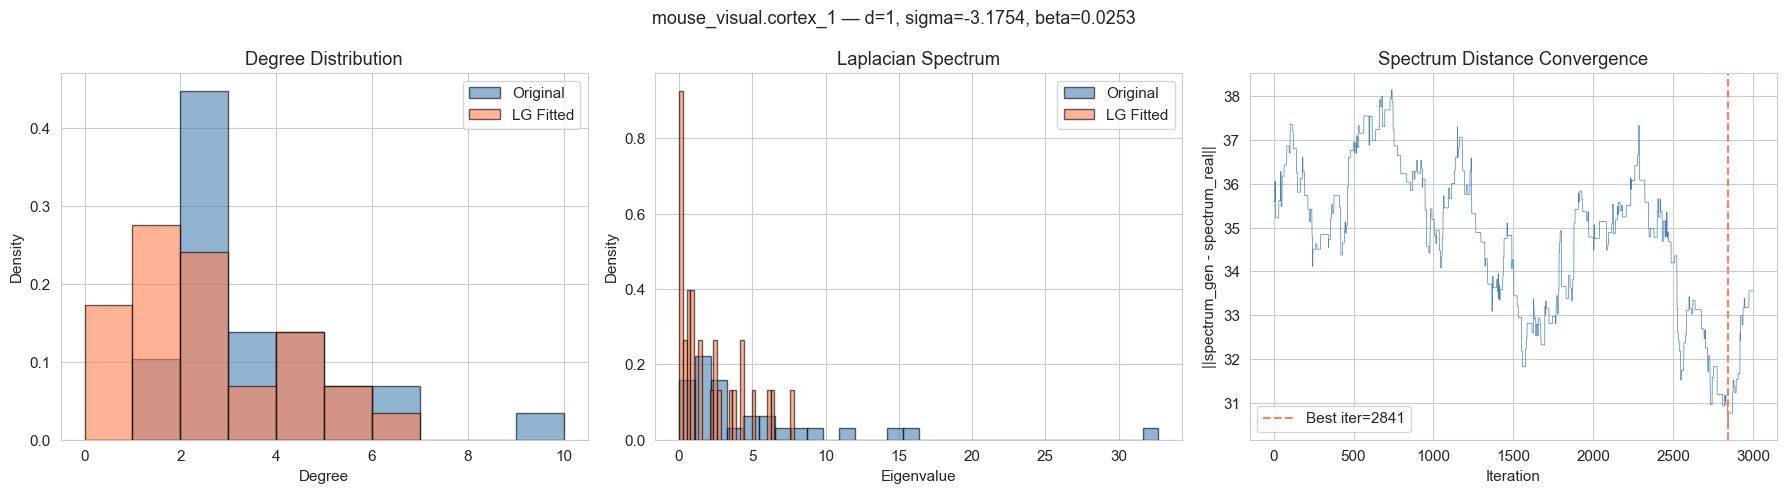

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# --- Degree distributions ---
orig_degrees = [d for _, d in G_small.degree()]
fitted_degrees = [d for _, d in fitter.fitted_graph.degree()]

axes[0].hist(orig_degrees, bins=range(0, max(orig_degrees)+2), density=True,
             alpha=0.6, label='Original', color='steelblue', edgecolor='black')
axes[0].hist(fitted_degrees, bins=range(0, max(fitted_degrees)+2), density=True,
             alpha=0.6, label='LG Fitted', color='coral', edgecolor='black')
axes[0].set_title('Degree Distribution')
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Density')
axes[0].legend()

# --- Spectral densities ---
orig_spec = nx.laplacian_spectrum(G_small)
fitted_spec = nx.laplacian_spectrum(fitter.fitted_graph)

axes[1].hist(orig_spec, bins=30, density=True, alpha=0.6, label='Original', color='steelblue', edgecolor='black')
axes[1].hist(fitted_spec, bins=30, density=True, alpha=0.6, label='LG Fitted', color='coral', edgecolor='black')
axes[1].set_title('Laplacian Spectrum')
axes[1].set_xlabel('Eigenvalue')
axes[1].set_ylabel('Density')
axes[1].legend()

# --- Convergence: spectrum diff over iterations ---
spec_diffs = fitter.metadata.get('spectrum_diffs', [])
if spec_diffs:
    axes[2].plot(spec_diffs, color='steelblue', linewidth=0.5)
    best_iter = fitter.metadata.get('best_iteration', 0)
    axes[2].axvline(best_iter, color='coral', linestyle='--', label=f'Best iter={best_iter}')
    axes[2].set_title('Spectrum Distance Convergence')
    axes[2].set_xlabel('Iteration')
    axes[2].set_ylabel('||spectrum_gen - spectrum_real||')
    axes[2].legend()

plt.suptitle(f'mouse_visual.cortex_1 — d={fitter.d}, sigma={fitter.metadata["sigma"]:.4f}, beta={fitter.metadata["beta"]:.4f}', fontsize=13)
plt.tight_layout()
plt.show()

---
## 7. Validate Fix 1.4 — Spectral density resolution (50 bins vs 10)

With 50 bins the GIC can distinguish structurally different graphs that 10 bins conflated.

In [9]:
gic_calc = GraphInformationCriterion(G_small, model='LG', log_graph=G_small, dist='L2')
hist, bin_edges = gic_calc.compute_spectral_density(G_small)

print(f'Number of histogram bins: {len(hist)}  (should be 50)')
print(f'Bin width: {bin_edges[1] - bin_edges[0]:.4f}  (should be 0.04)')
assert len(hist) == 50, f'FAIL: Expected 50 bins, got {len(hist)}'
print('PASS: Spectral density uses 50 bins.')
print()

# Demonstrate discrimination power: compare identical vs different graphs
G_er = nx.erdos_renyi_graph(G_small.number_of_nodes(), 0.1, seed=42)
G_ba = nx.barabasi_albert_graph(G_small.number_of_nodes(), 2, seed=42)

gic_self = GraphInformationCriterion(G_small, model='LG', log_graph=G_small, dist='KL').calculate_gic()
gic_er   = GraphInformationCriterion(G_small, model='LG', log_graph=G_er, dist='KL').calculate_gic()
gic_ba   = GraphInformationCriterion(G_small, model='LG', log_graph=G_ba, dist='KL').calculate_gic()

print(f'GIC(real vs real):  {gic_self:.6f}  (should be ~0)')
print(f'GIC(real vs ER):    {gic_er:.6f}')
print(f'GIC(real vs BA):    {gic_ba:.6f}')

Number of histogram bins: 50  (should be 50)
Bin width: 0.0400  (should be 0.04)
PASS: Spectral density uses 50 bins.

GIC(real vs real):  0.000000  (should be ~0)
GIC(real vs ER):    10.978463
GIC(real vs BA):    8.196052


---
## 8. Model comparison: LG vs ER / WS / BA on medium connectome

Full end-to-end test using `GraphModelComparator`.

In [10]:
comparator = GraphModelComparator(
    d_list=[0, 1, 2],
    lg_params={
        'max_iterations': 3000,
        'patience': 500,
        'edge_delta': None,
        'min_gic_threshold': 5,
        'er_p': 0.05,
    },
    other_model_n_runs=3,
    dist_type='KL',
    verbose=True,
    other_models=['ER', 'WS', 'BA'],
    # NOTE: params list must be aligned 1:1 with other_models (pre-existing index bug)
    other_model_params=[
        {'lo': 0.01, 'hi': 0.25},                                             # ER: p
        {'k': {'lo': 2, 'hi': 10, 'step': 2}, 'p': {'lo': 0.01, 'hi': 0.5}}, # WS: k, p
        {'lo': 1, 'hi': 8},                                                    # BA: m
    ],
    other_model_grid_points=5,
)

comparator.compare(original_graph=G_medium, graph_filepath='mixed.species_brain_1.graphml')
print('\n=== Summary ===')
comparator.summary_df


============================== Processing Graph: mixed.species_brain_1.graphml ==============================

--- Fitting Logit Graph (LG) model ---
Running LG generation for d=0...


🔄 Optimizing Graph:   0%|          | 0/3000 [00:00<?, ?it/s] 

🎉 GIC threshold 5 reached at iteration 1 (GIC: 4.6720)
🔍 Starting convergence check based on spectrum difference (Patience: 500)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 500 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 341
   📊 Best spectrum difference: 169.8401
   🔗 Edges in best graph: 107 (Real graph edges: 730)
d=0: GIC=3.2303, sigma=-4.5983
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/3000 [00:00<?, ?it/s] 

🎉 GIC threshold 5 reached at iteration 1 (GIC: 3.8909)
🔍 Starting convergence check based on spectrum difference (Patience: 500)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 500 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 0
   📊 Best spectrum difference: 170.5443
   🔗 Edges in best graph: 104 (Real graph edges: 730)
d=1: GIC=3.8909, sigma=-4.6667
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/3000 [00:00<?, ?it/s] 

🎉 GIC threshold 5 reached at iteration 20 (GIC: 1.2592)
🔍 Starting convergence check based on spectrum difference (Patience: 500)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 500 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 0
   📊 Best spectrum difference: 169.5990
   🔗 Edges in best graph: 107 (Real graph edges: 730)
d=2: GIC=5.2393, sigma=-20.1749
Best LG fit found with GIC: 3.2303

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.358432421480956
Testing the selected model for WS
WS gic: 2.3117193965158926
Testing the selected model for BA
BA gic: 1.418529347372849
ER fitting - GIC: 1.3584, Param: 0.2500
BA fitting - GIC: 1.4185, Param: 8.0000
WS fitting - GIC: 2.3117, Param: 80.0100

--- Calculating graph attributes ---

=== Summary ===


,graph_filename,model,gic_value,param,fit_success,nodes,edges,density,avg_clustering,avg_path_length,diameter,assortativity,num_components,largest_component_size
0,mixed.species_brain_1.graphml,Original,NaN,N/A,True,65,730,0.350962,0.661366,1.699519,3,-0.025391,1,65
1,mixed.species_brain_1.graphml,LG,3.230335,"d=0, sigma=-4.5983",True,65,107,0.051442,0.061026,3.620040,10,-0.053993,2,64
2,mixed.species_brain_1.graphml,ER,1.358432,0.25,True,65,477,0.229327,0.224729,1.793269,3,-0.035871,1,65
3,mixed.species_brain_1.graphml,BA,1.418529,8.0,True,65,456,0.219231,0.334974,1.824519,3,-0.119088,1,65
4,mixed.species_brain_1.graphml,WS,2.311719,80.01,True,65,715,0.343750,0.335047,1.656250,2,-0.044372,1,65


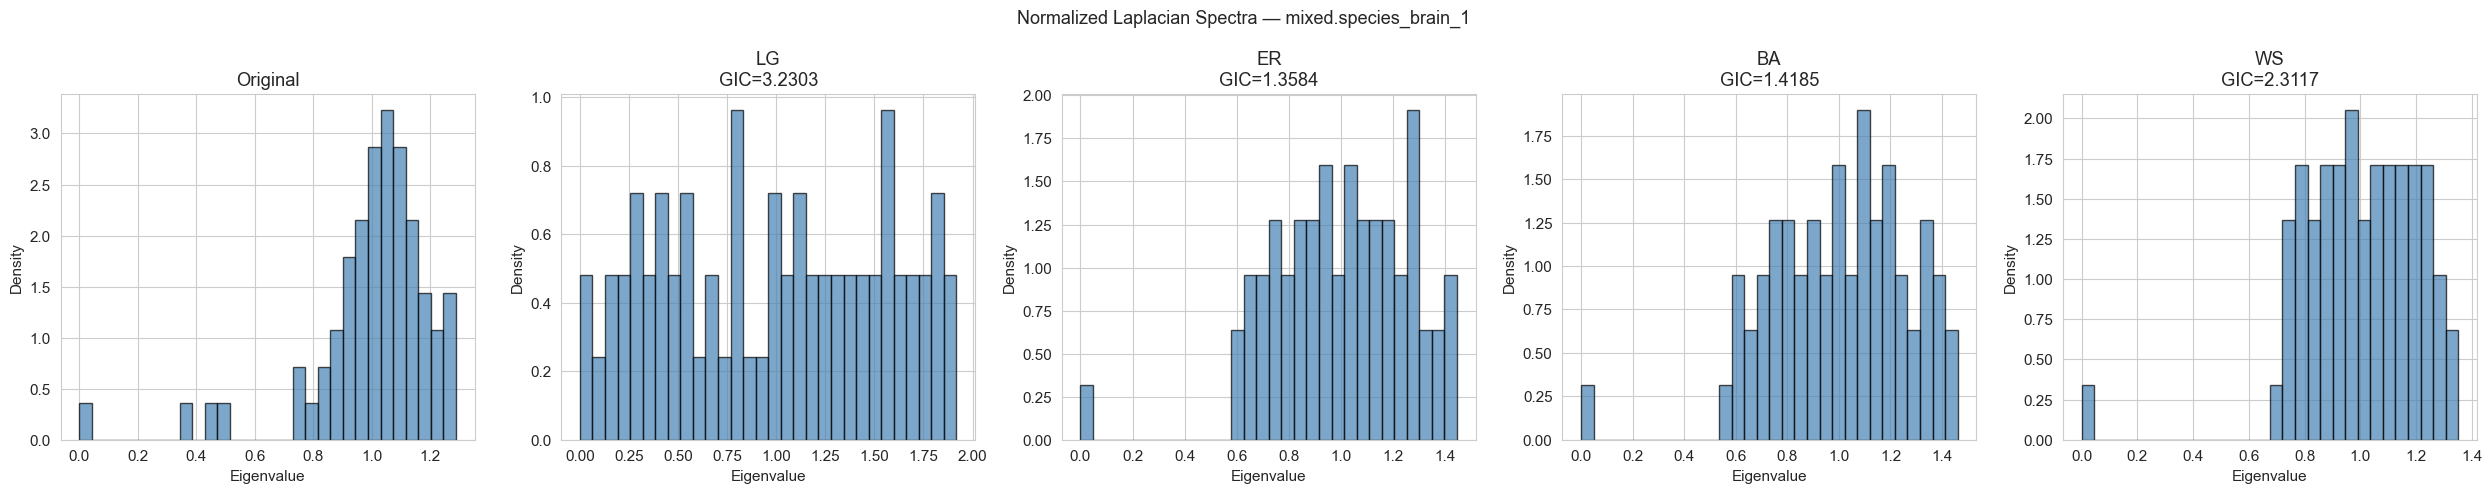

In [11]:
fig, axes = plt.subplots(1, len(comparator.fitted_graphs_data), figsize=(5 * len(comparator.fitted_graphs_data), 5))
if not hasattr(axes, '__len__'):
    axes = [axes]

for ax, (model_name, data) in zip(axes, comparator.fitted_graphs_data.items()):
    G = data['graph']
    if G is None:
        ax.set_title(f'{model_name} (failed)')
        ax.axis('off')
        continue

    degrees = [d for _, d in G.degree()]
    spec = nx.normalized_laplacian_matrix(G)
    eigs = np.linalg.eigvalsh(spec.todense())

    ax.hist(eigs, bins=30, density=True, alpha=0.7, color='steelblue', edgecolor='black')
    gic_val = data['metadata'].get('gic_value', np.nan)
    ax.set_title(f'{model_name}\nGIC={gic_val:.4f}' if np.isfinite(gic_val) else model_name)
    ax.set_xlabel('Eigenvalue')
    ax.set_ylabel('Density')

plt.suptitle('Normalized Laplacian Spectra — mixed.species_brain_1', fontsize=13)
plt.tight_layout()
plt.show()

---
## 9. Simulation from known parameters

Use the estimated sigma and beta from the fitter to simulate a new graph
via `LogitGraphSimulation`, verifying the generation path uses both parameters.

In [12]:
sigma_est = fitter.metadata['sigma']
beta_est = fitter.metadata['beta']

sim = LogitGraphSimulation(
    n=G_small.number_of_nodes(),
    d=1,
    sigma=sigma_est,
    beta=beta_est,
    er_p=0.05,
    n_iteration=3000,
    warm_up=500,
    patience=1000,
    verbose=True,
)
sim.simulate()

print(f'\nSimulated graph: {sim.simulated_graph.number_of_nodes()} nodes, {sim.simulated_graph.number_of_edges()} edges')
print(f'Original graph:  {G_small.number_of_nodes()} nodes, {G_small.number_of_edges()} edges')


==================== Simulating Logit Graph ====================
Parameters - n: 29, d: 1, sigma: -3.1754, alpha: 1.0000, beta: 0.0253, er_p: 0.05


Generating graph:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation successful - Nodes: 29, Edges: 16

Simulated graph: 29 nodes, 16 edges
Original graph:  29 nodes, 44 edges


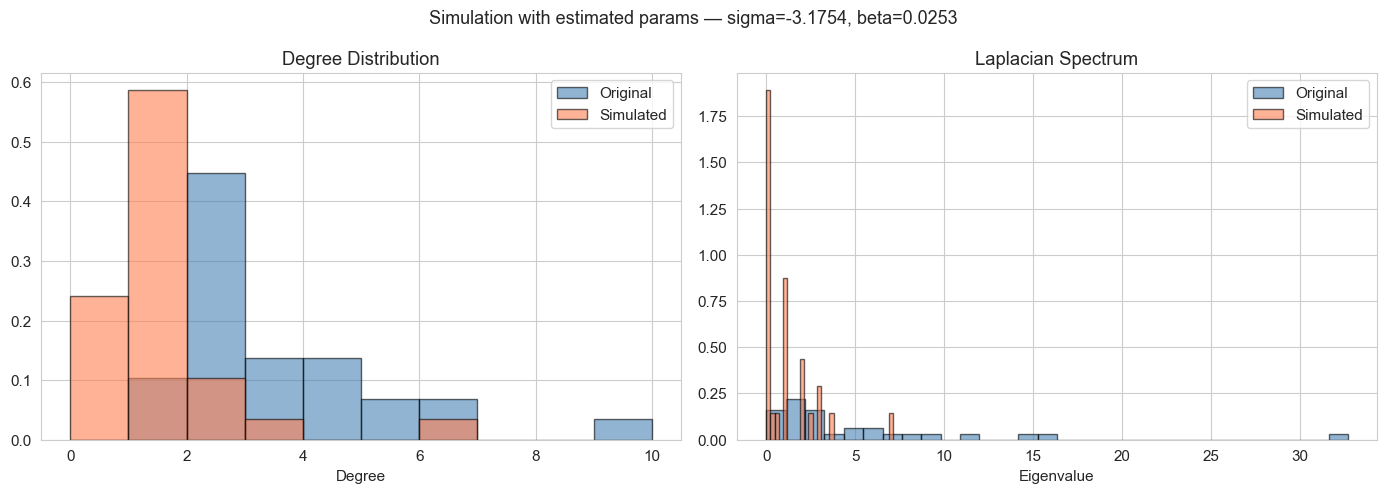

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Degree distribution comparison
orig_deg = [d for _, d in G_small.degree()]
sim_deg = [d for _, d in sim.simulated_graph.degree()]

axes[0].hist(orig_deg, bins=range(0, max(orig_deg)+2), density=True,
             alpha=0.6, label='Original', color='steelblue', edgecolor='black')
axes[0].hist(sim_deg, bins=range(0, max(max(sim_deg, default=1), 1)+2), density=True,
             alpha=0.6, label='Simulated', color='coral', edgecolor='black')
axes[0].set_title('Degree Distribution')
axes[0].set_xlabel('Degree')
axes[0].legend()

# Spectrum comparison
orig_spec = nx.laplacian_spectrum(G_small)
sim_spec = nx.laplacian_spectrum(sim.simulated_graph)

axes[1].hist(orig_spec, bins=30, density=True, alpha=0.6, label='Original', color='steelblue', edgecolor='black')
axes[1].hist(sim_spec, bins=30, density=True, alpha=0.6, label='Simulated', color='coral', edgecolor='black')
axes[1].set_title('Laplacian Spectrum')
axes[1].set_xlabel('Eigenvalue')
axes[1].legend()

plt.suptitle(f'Simulation with estimated params — sigma={sigma_est:.4f}, beta={beta_est:.4f}', fontsize=13)
plt.tight_layout()
plt.show()

---
## Summary of validations

| Fix | What | Status |
|-----|------|--------|
| 1.5 | `degree_vertex` BFS collects all hops 1..d | Verified above |
| 1.2 | `logit(i,j) == logit(j,i)` for all pairs | Verified above |
| 1.1 | `sigma` **and** `beta` estimated and passed | Verified in fitter metadata |
| 1.4 | GIC spectral histogram uses 50 bins | Verified above |

---
# Part 2 — Parameter Exploration & Baseline Comparison

This section adds:
- **10.** Interactive exploration of how `sigma`, `beta`, and `d` shape the generated graph
- **11.** Side-by-side comparison with ER, BA, and WS baselines on the connectome

---
## 10. Effect of sigma, beta, and d on graph generation

We sweep each parameter while holding others fixed, using the small connectome
(29 nodes) for fast iteration. Each configuration runs `LogitGraphSimulation`
and we collect degree distribution, edge count, clustering, and spectrum.

In [14]:
from scipy.special import expit
from scipy.stats import ks_2samp

N_NODES = G_small.number_of_nodes()
N_ITER = 3000
WARM_UP = 500
PATIENCE = 1000

def run_sim(n, d, sigma, beta, er_p=0.05, n_iter=N_ITER, seed=None):
    """Run a single LogitGraphSimulation and return the graph + metadata."""
    if seed is not None:
        np.random.seed(seed)
    sim = LogitGraphSimulation(
        n=n, d=d, sigma=sigma, beta=beta, er_p=er_p,
        n_iteration=n_iter, warm_up=WARM_UP, patience=PATIENCE, verbose=False,
    )
    sim.simulate()
    return sim.simulated_graph, sim.metadata

def graph_stats(G):
    """Compute summary statistics for a networkx graph."""
    if G is None or G.number_of_nodes() == 0:
        return {'edges': 0, 'density': 0, 'avg_degree': 0,
                'avg_clustering': 0, 'max_degree': 0}
    degrees = [d for _, d in G.degree()]
    return {
        'edges': G.number_of_edges(),
        'density': nx.density(G),
        'avg_degree': np.mean(degrees),
        'max_degree': max(degrees),
        'avg_clustering': nx.average_clustering(G),
    }

print(f'Helper functions defined. Target graph: {N_NODES} nodes, {G_small.number_of_edges()} edges.')

Helper functions defined. Target graph: 29 nodes, 44 edges.


### 10a. Sweep sigma (intercept controls baseline edge density)

Generating graph:   0%|          | 0/3000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/3000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/3000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/3000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/3000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/3000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/3000 [00:00<?, ?it/s]

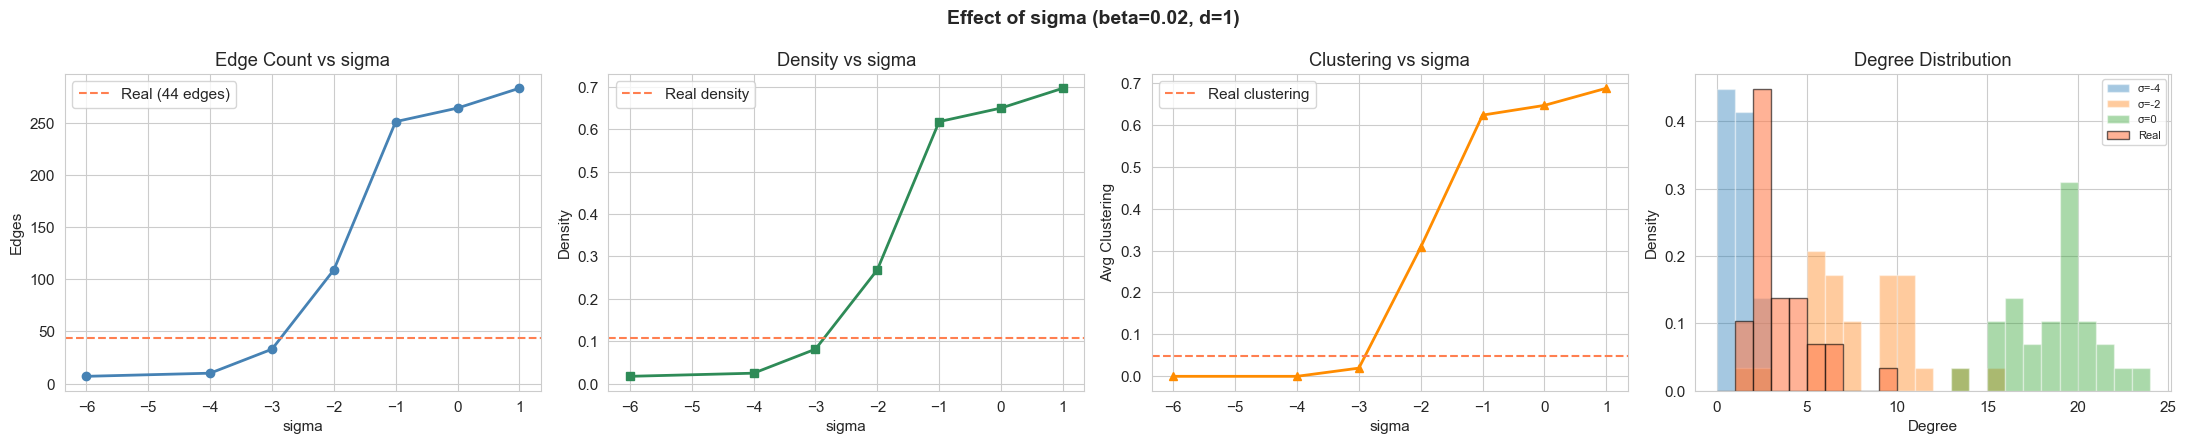

 edges  density  avg_degree  max_degree  avg_clustering  sigma
     7 0.017241    0.482759           2        0.000000     -6
    10 0.024631    0.689655           2        0.000000     -4
    33 0.081281    2.275862           6        0.019540     -3
   109 0.268473    7.517241          15        0.307926     -2
   251 0.618227   17.310345          22        0.623050     -1
   264 0.650246   18.206897          23        0.646250      0
   283 0.697044   19.517241          25        0.687137      1


In [15]:
sigma_values = [-6, -4, -3, -2, -1, 0, 1]
fixed_beta, fixed_d = 0.02, 1

rows = []
graphs_by_sigma = {}
for sigma in sigma_values:
    G_gen, meta = run_sim(N_NODES, d=fixed_d, sigma=sigma, beta=fixed_beta, seed=42)
    stats = graph_stats(G_gen)
    stats['sigma'] = sigma
    rows.append(stats)
    graphs_by_sigma[sigma] = G_gen

df_sigma = pd.DataFrame(rows)

fig, axes = plt.subplots(1, 4, figsize=(22, 4.5))

# 1) Edges vs sigma
axes[0].plot(df_sigma['sigma'], df_sigma['edges'], 'o-', color='steelblue', linewidth=2)
axes[0].axhline(G_small.number_of_edges(), color='coral', ls='--', label=f'Real ({G_small.number_of_edges()} edges)')
axes[0].set_xlabel('sigma'); axes[0].set_ylabel('Edges'); axes[0].set_title('Edge Count vs sigma')
axes[0].legend()

# 2) Density vs sigma
axes[1].plot(df_sigma['sigma'], df_sigma['density'], 's-', color='seagreen', linewidth=2)
axes[1].axhline(nx.density(G_small), color='coral', ls='--', label='Real density')
axes[1].set_xlabel('sigma'); axes[1].set_ylabel('Density'); axes[1].set_title('Density vs sigma')
axes[1].legend()

# 3) Clustering vs sigma
axes[2].plot(df_sigma['sigma'], df_sigma['avg_clustering'], '^-', color='darkorange', linewidth=2)
axes[2].axhline(nx.average_clustering(G_small), color='coral', ls='--', label='Real clustering')
axes[2].set_xlabel('sigma'); axes[2].set_ylabel('Avg Clustering'); axes[2].set_title('Clustering vs sigma')
axes[2].legend()

# 4) Degree distributions for selected sigmas
for sigma in [-4, -2, 0]:
    G = graphs_by_sigma[sigma]
    if G is not None:
        degs = sorted([d for _, d in G.degree()])
        axes[3].hist(degs, bins=range(0, max(degs)+2), density=True, alpha=0.4, label=f'σ={sigma}')
orig_degs = sorted([d for _, d in G_small.degree()])
axes[3].hist(orig_degs, bins=range(0, max(orig_degs)+2), density=True, alpha=0.6,
             color='coral', edgecolor='black', label='Real')
axes[3].set_xlabel('Degree'); axes[3].set_ylabel('Density'); axes[3].set_title('Degree Distribution')
axes[3].legend(fontsize=8)

plt.suptitle(f'Effect of sigma (beta={fixed_beta}, d={fixed_d})', fontsize=14, fontweight='bold')
plt.tight_layout(); plt.show()
print(df_sigma.to_string(index=False))

### 10b. Sweep beta (controls how neighbourhood degree affects connectivity)

Generating graph:   0%|          | 0/3000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/3000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/3000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/3000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/3000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/3000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/3000 [00:00<?, ?it/s]

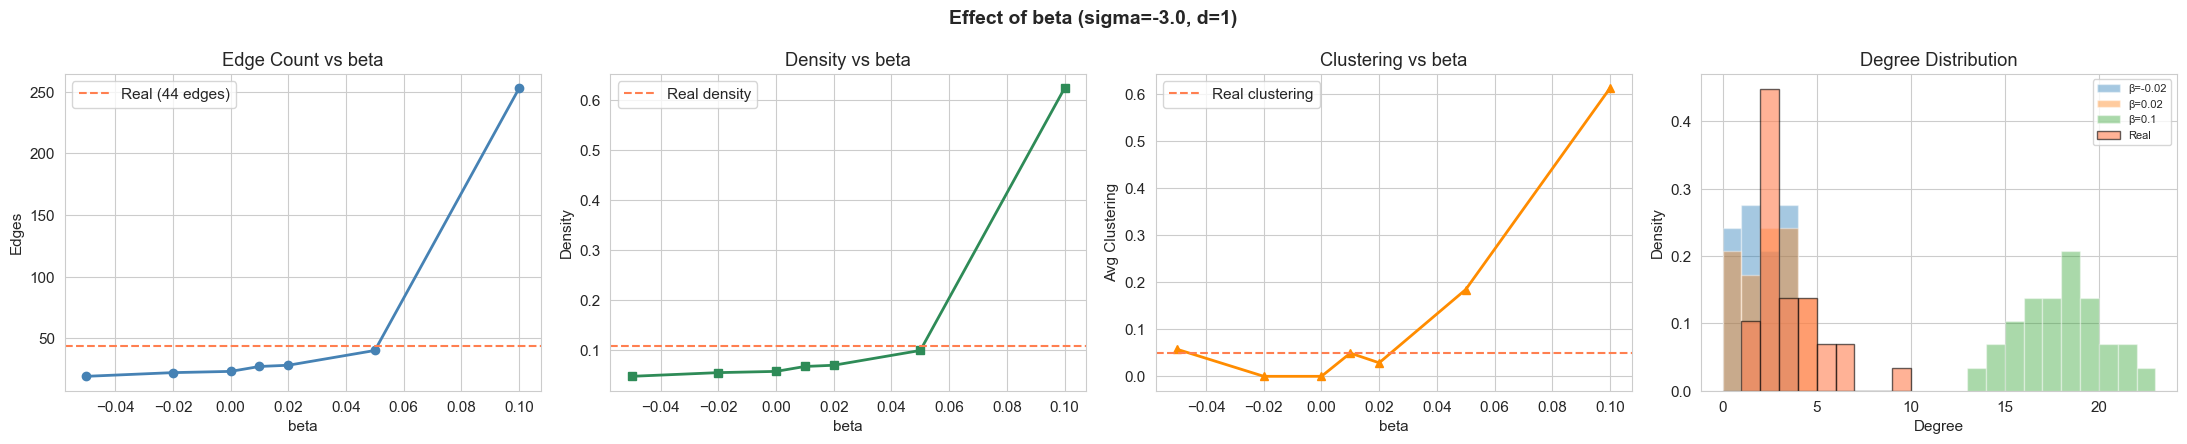

 edges  density  avg_degree  max_degree  avg_clustering  beta
    19 0.046798    1.310345           3        0.057471 -0.05
    22 0.054187    1.517241           3        0.000000 -0.02
    23 0.056650    1.586207           4        0.000000  0.00
    27 0.066502    1.862069           5        0.049425  0.01
    28 0.068966    1.931034           4        0.028736  0.02
    40 0.098522    2.758621           7        0.184729  0.05
   253 0.623153   17.448276          22        0.613229  0.10


In [16]:
beta_values = [-0.05, -0.02, 0, 0.01, 0.02, 0.05, 0.1]
fixed_sigma, fixed_d = -3.0, 1

rows = []
graphs_by_beta = {}
for beta in beta_values:
    G_gen, meta = run_sim(N_NODES, d=fixed_d, sigma=fixed_sigma, beta=beta, seed=42)
    stats = graph_stats(G_gen)
    stats['beta'] = beta
    rows.append(stats)
    graphs_by_beta[beta] = G_gen

df_beta = pd.DataFrame(rows)

fig, axes = plt.subplots(1, 4, figsize=(22, 4.5))

axes[0].plot(df_beta['beta'], df_beta['edges'], 'o-', color='steelblue', linewidth=2)
axes[0].axhline(G_small.number_of_edges(), color='coral', ls='--', label=f'Real ({G_small.number_of_edges()} edges)')
axes[0].set_xlabel('beta'); axes[0].set_ylabel('Edges'); axes[0].set_title('Edge Count vs beta')
axes[0].legend()

axes[1].plot(df_beta['beta'], df_beta['density'], 's-', color='seagreen', linewidth=2)
axes[1].axhline(nx.density(G_small), color='coral', ls='--', label='Real density')
axes[1].set_xlabel('beta'); axes[1].set_ylabel('Density'); axes[1].set_title('Density vs beta')
axes[1].legend()

axes[2].plot(df_beta['beta'], df_beta['avg_clustering'], '^-', color='darkorange', linewidth=2)
axes[2].axhline(nx.average_clustering(G_small), color='coral', ls='--', label='Real clustering')
axes[2].set_xlabel('beta'); axes[2].set_ylabel('Avg Clustering'); axes[2].set_title('Clustering vs beta')
axes[2].legend()

for beta in [-0.02, 0.02, 0.1]:
    G = graphs_by_beta[beta]
    if G is not None:
        degs = sorted([d for _, d in G.degree()])
        axes[3].hist(degs, bins=range(0, max(degs)+2), density=True, alpha=0.4, label=f'β={beta}')
axes[3].hist(orig_degs, bins=range(0, max(orig_degs)+2), density=True, alpha=0.6,
             color='coral', edgecolor='black', label='Real')
axes[3].set_xlabel('Degree'); axes[3].set_ylabel('Density'); axes[3].set_title('Degree Distribution')
axes[3].legend(fontsize=8)

plt.suptitle(f'Effect of beta (sigma={fixed_sigma}, d={fixed_d})', fontsize=14, fontweight='bold')
plt.tight_layout(); plt.show()
print(df_beta.to_string(index=False))

### 10c. Sweep d (neighbourhood depth — how far the model "looks")

Generating graph:   0%|          | 0/3000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/3000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/3000 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/3000 [00:00<?, ?it/s]

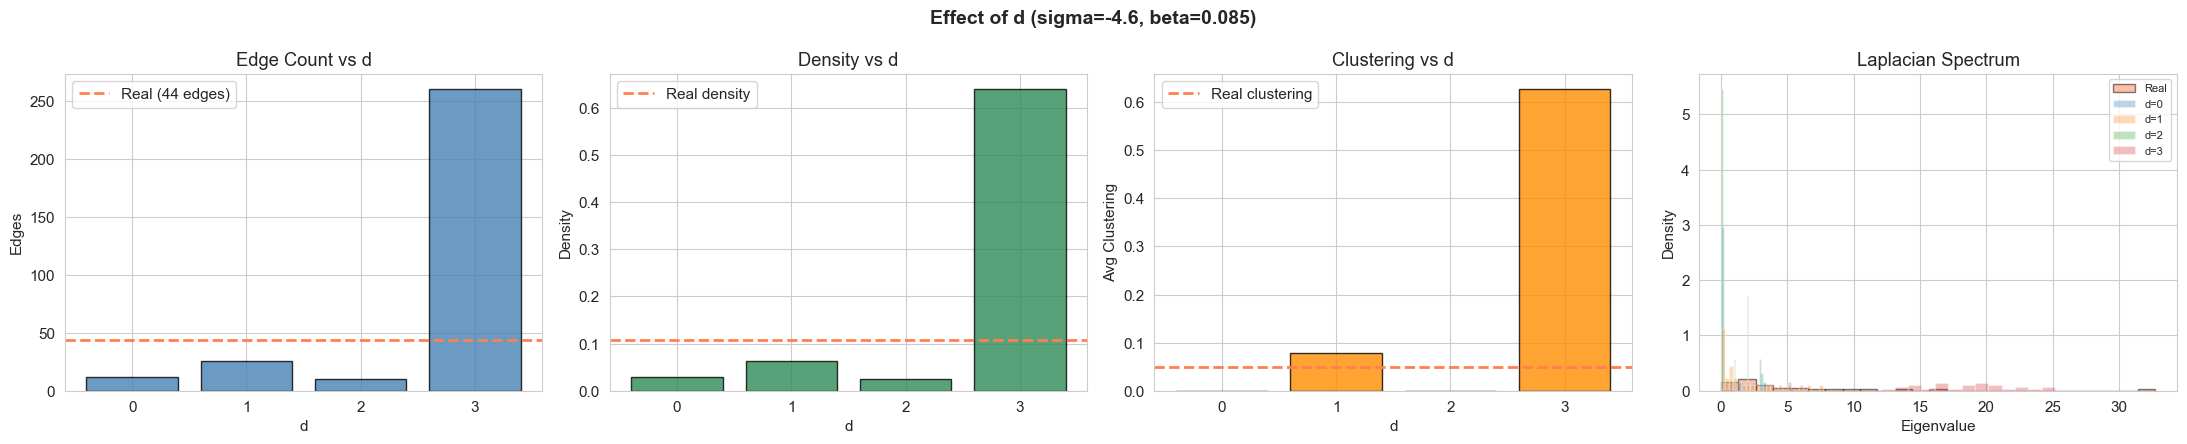

 edges  density  avg_degree  max_degree  avg_clustering  d
    12 0.029557    0.827586           4        0.000000  0
    26 0.064039    1.793103           6        0.079310  1
    10 0.024631    0.689655           2        0.000000  2
   260 0.640394   17.931034          23        0.627322  3


In [17]:
d_values = [0, 1, 2, 3]
# Use the estimated sigma/beta for d=0 from earlier estimation as a baseline
fixed_sigma_d, fixed_beta_d = -4.6, 0.085

rows = []
graphs_by_d = {}
for d in d_values:
    G_gen, meta = run_sim(N_NODES, d=d, sigma=fixed_sigma_d, beta=fixed_beta_d, seed=42)
    stats = graph_stats(G_gen)
    stats['d'] = d
    rows.append(stats)
    graphs_by_d[d] = G_gen

df_d = pd.DataFrame(rows)

fig, axes = plt.subplots(1, 4, figsize=(22, 4.5))

axes[0].bar(df_d['d'], df_d['edges'], color='steelblue', alpha=0.8, edgecolor='black')
axes[0].axhline(G_small.number_of_edges(), color='coral', ls='--', linewidth=2, label=f'Real ({G_small.number_of_edges()} edges)')
axes[0].set_xlabel('d'); axes[0].set_ylabel('Edges'); axes[0].set_title('Edge Count vs d')
axes[0].set_xticks(d_values); axes[0].legend()

axes[1].bar(df_d['d'], df_d['density'], color='seagreen', alpha=0.8, edgecolor='black')
axes[1].axhline(nx.density(G_small), color='coral', ls='--', linewidth=2, label='Real density')
axes[1].set_xlabel('d'); axes[1].set_ylabel('Density'); axes[1].set_title('Density vs d')
axes[1].set_xticks(d_values); axes[1].legend()

axes[2].bar(df_d['d'], df_d['avg_clustering'], color='darkorange', alpha=0.8, edgecolor='black')
axes[2].axhline(nx.average_clustering(G_small), color='coral', ls='--', linewidth=2, label='Real clustering')
axes[2].set_xlabel('d'); axes[2].set_ylabel('Avg Clustering'); axes[2].set_title('Clustering vs d')
axes[2].set_xticks(d_values); axes[2].legend()

# Spectrum overlay per d
real_spec = nx.laplacian_spectrum(G_small)
axes[3].hist(real_spec, bins=25, density=True, alpha=0.5, color='coral', edgecolor='black', label='Real')
for d in d_values:
    G = graphs_by_d[d]
    if G is not None and G.number_of_edges() > 0:
        spec = nx.laplacian_spectrum(G)
        axes[3].hist(spec, bins=25, density=True, alpha=0.3, label=f'd={d}')
axes[3].set_xlabel('Eigenvalue'); axes[3].set_ylabel('Density'); axes[3].set_title('Laplacian Spectrum')
axes[3].legend(fontsize=8)

plt.suptitle(f'Effect of d (sigma={fixed_sigma_d}, beta={fixed_beta_d})', fontsize=14, fontweight='bold')
plt.tight_layout(); plt.show()
print(df_d.to_string(index=False))

---
## 11. Interactive parameter explorer

Use sliders to change `sigma`, `beta`, and `d` and see the generated graph,
its degree distribution, and spectrum update live.

In [18]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Reference stats
real_degrees = sorted([d for _, d in G_small.degree()])
real_spectrum = nx.laplacian_spectrum(G_small)
real_edges = G_small.number_of_edges()
real_clustering = nx.average_clustering(G_small)
real_density = nx.density(G_small)

output = widgets.Output()

def interactive_logit_graph(sigma, beta, d, n_iter, seed):
    with output:
        clear_output(wait=True)
        np.random.seed(seed)
        G_gen, meta = run_sim(N_NODES, d=d, sigma=sigma, beta=beta, n_iter=n_iter, seed=seed)
        
        if G_gen is None or G_gen.number_of_edges() == 0:
            print('Generated graph has no edges — try increasing sigma or beta.')
            return
        
        stats = graph_stats(G_gen)
        gen_degrees = sorted([d for _, d in G_gen.degree()])
        gen_spectrum = nx.laplacian_spectrum(G_gen)
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        
        # ---- Row 1: Graph topology ----
        # 1a) Generated graph layout
        pos = nx.spring_layout(G_gen, seed=42, k=0.6)
        node_colors = [G_gen.degree(n) for n in G_gen.nodes()]
        nx.draw_networkx(G_gen, pos, ax=axes[0, 0], node_size=120, width=0.5,
                         node_color=node_colors, cmap=plt.cm.viridis,
                         with_labels=False, alpha=0.9, edge_color='lightgray')
        axes[0, 0].set_title(f'Generated LG (edges={stats["edges"]})')
        axes[0, 0].axis('off')
        
        # 1b) Real graph layout
        pos_real = nx.spring_layout(G_small, seed=42, k=0.6)
        real_node_colors = [G_small.degree(n) for n in G_small.nodes()]
        nx.draw_networkx(G_small, pos_real, ax=axes[0, 1], node_size=120, width=0.5,
                         node_color=real_node_colors, cmap=plt.cm.viridis,
                         with_labels=False, alpha=0.9, edge_color='lightgray')
        axes[0, 1].set_title(f'Real Connectome (edges={real_edges})')
        axes[0, 1].axis('off')
        
        # 1c) Summary bar chart
        metrics = ['Edges', 'Avg Degree', 'Clustering', 'Max Degree']
        gen_vals = [stats['edges'], stats['avg_degree'], stats['avg_clustering'], stats['max_degree']]
        real_vals = [real_edges, np.mean(real_degrees), real_clustering, max(real_degrees)]
        x = np.arange(len(metrics))
        w = 0.35
        axes[0, 2].bar(x - w/2, gen_vals, w, label='Generated', color='steelblue', alpha=0.8)
        axes[0, 2].bar(x + w/2, real_vals, w, label='Real', color='coral', alpha=0.8)
        axes[0, 2].set_xticks(x); axes[0, 2].set_xticklabels(metrics, fontsize=9)
        axes[0, 2].set_title('Graph Metrics Comparison'); axes[0, 2].legend()
        
        # ---- Row 2: Distributions ----
        # 2a) Degree distribution
        max_deg = max(max(gen_degrees, default=1), max(real_degrees))
        bins_deg = range(0, max_deg + 2)
        axes[1, 0].hist(real_degrees, bins=bins_deg, density=True, alpha=0.6,
                        color='coral', edgecolor='black', label='Real')
        axes[1, 0].hist(gen_degrees, bins=bins_deg, density=True, alpha=0.6,
                        color='steelblue', edgecolor='black', label='Generated')
        axes[1, 0].set_xlabel('Degree'); axes[1, 0].set_ylabel('Density')
        axes[1, 0].set_title('Degree Distribution'); axes[1, 0].legend()
        
        # 2b) Laplacian spectrum
        axes[1, 1].hist(real_spectrum, bins=25, density=True, alpha=0.6,
                        color='coral', edgecolor='black', label='Real')
        axes[1, 1].hist(gen_spectrum, bins=25, density=True, alpha=0.6,
                        color='steelblue', edgecolor='black', label='Generated')
        axes[1, 1].set_xlabel('Eigenvalue'); axes[1, 1].set_ylabel('Density')
        axes[1, 1].set_title('Laplacian Spectrum'); axes[1, 1].legend()
        
        # 2c) Edge probability curve
        s_range = np.linspace(0, 50, 200)
        p_edge = expit(sigma + beta * s_range)
        axes[1, 2].plot(s_range, p_edge, color='steelblue', linewidth=2)
        axes[1, 2].fill_between(s_range, p_edge, alpha=0.15, color='steelblue')
        axes[1, 2].axhline(0.5, color='gray', ls=':', alpha=0.5)
        axes[1, 2].set_xlabel('S_i + S_j (sum of neighbourhood degrees)')
        axes[1, 2].set_ylabel('P(edge)')
        axes[1, 2].set_title(f'Edge Probability: logistic({sigma:.1f} + {beta:.3f}·S)')
        axes[1, 2].set_ylim(-0.05, 1.05)
        
        plt.suptitle(f'sigma={sigma:.2f}  beta={beta:.4f}  d={d}  iterations={n_iter}  seed={seed}',
                     fontsize=13, fontweight='bold')
        plt.tight_layout()
        plt.show()

sigma_slider = widgets.FloatSlider(value=-3.0, min=-8.0, max=2.0, step=0.5,
                                    description='sigma:', style={'description_width': '60px'})
beta_slider = widgets.FloatSlider(value=0.02, min=-0.1, max=0.2, step=0.005,
                                   description='beta:', readout_format='.3f',
                                   style={'description_width': '60px'})
d_slider = widgets.IntSlider(value=1, min=0, max=3, description='d:',
                              style={'description_width': '60px'})
iter_slider = widgets.IntSlider(value=3000, min=500, max=10000, step=500,
                                 description='iterations:', style={'description_width': '80px'})
seed_slider = widgets.IntSlider(value=42, min=0, max=200, step=1,
                                 description='seed:', style={'description_width': '60px'})

ui = widgets.VBox([
    widgets.HBox([sigma_slider, beta_slider, d_slider]),
    widgets.HBox([iter_slider, seed_slider]),
])

interactive = widgets.interactive_output(
    interactive_logit_graph,
    {'sigma': sigma_slider, 'beta': beta_slider, 'd': d_slider,
     'n_iter': iter_slider, 'seed': seed_slider}
)

display(ui, output)
# Trigger initial render
interactive_logit_graph(sigma_slider.value, beta_slider.value, d_slider.value,
                        iter_slider.value, seed_slider.value)

Output()

---
## 12. Baseline comparison: LG vs ER, BA, WS (parameter-matched)

For each baseline model we estimate the best-fitting parameter from the
real connectome, generate a graph, and compare all models on the same axes.
We use the **medium connectome** (65 nodes, 730 edges) for a richer comparison.

In [19]:
from logit_graph.param_estimator import GraphParameterEstimator

# ---- Reference graph ----
G_ref = G_medium  # 65 nodes, 730 edges
n_ref = G_ref.number_of_nodes()
m_ref = G_ref.number_of_edges()
avg_deg_ref = 2 * m_ref / n_ref

print(f'Reference graph: {n_ref} nodes, {m_ref} edges, avg_degree={avg_deg_ref:.1f}')
print()

# ---- 1. Logit Graph (estimated from data) ----
print('--- Estimating LG parameters ---')
est_lg = LogitRegEstimator(nx.to_numpy_array(G_ref), d=1, verbose=False)
feat, lab = est_lg.get_features_labels()
_, params_lg, _ = est_lg.estimate_parameters(l1_wt=1, alpha=0, features=feat, labels=lab)
sigma_lg, beta_lg = params_lg[0], params_lg[1]
print(f'  LG estimated: sigma={sigma_lg:.4f}, beta={beta_lg:.6f}')

G_lg, _ = run_sim(n_ref, d=1, sigma=sigma_lg, beta=beta_lg, n_iter=3000, seed=42)
print(f'  LG generated:  {G_lg.number_of_edges()} edges')

# ---- 2. Erdos-Renyi (match density) ----
p_er = nx.density(G_ref)
G_er = nx.erdos_renyi_graph(n_ref, p_er, seed=42)
print(f'\n  ER (p={p_er:.4f}): {G_er.number_of_edges()} edges')

# ---- 3. Barabasi-Albert (match avg degree / 2) ----
m_ba = max(1, int(round(avg_deg_ref / 2)))
G_ba = nx.barabasi_albert_graph(n_ref, m_ba, seed=42)
print(f'  BA (m={m_ba}): {G_ba.number_of_edges()} edges')

# ---- 4. Watts-Strogatz (match avg degree, sweep p) ----
k_ws = max(2, int(round(avg_deg_ref)))
if k_ws % 2 != 0:
    k_ws += 1

best_ws, best_ws_gic = None, float('inf')
for p_ws in np.linspace(0.01, 0.8, 20):
    G_ws_candidate = nx.watts_strogatz_graph(n_ref, k_ws, p_ws, seed=42)
    gic_ws = GraphInformationCriterion(G_ref, model='LG', log_graph=G_ws_candidate, dist='KL').calculate_gic()
    if gic_ws < best_ws_gic:
        best_ws_gic = gic_ws
        best_ws = (G_ws_candidate, p_ws)

G_ws, p_ws = best_ws
print(f'  WS (k={k_ws}, p={p_ws:.3f}): {G_ws.number_of_edges()} edges')

print('\nAll baseline graphs generated.')

Reference graph: 65 nodes, 730 edges, avg_degree=22.5

--- Estimating LG parameters ---
  LG estimated: sigma=-4.6667, beta=0.003100


Generating graph:   0%|          | 0/3000 [00:00<?, ?it/s]

  LG generated:  77 edges

  ER (p=0.3510): 721 edges
  BA (m=11): 594 edges
  WS (k=22, p=0.176): 715 edges

All baseline graphs generated.


### 12a. Visual comparison — graph layouts, degree, spectrum, and metrics

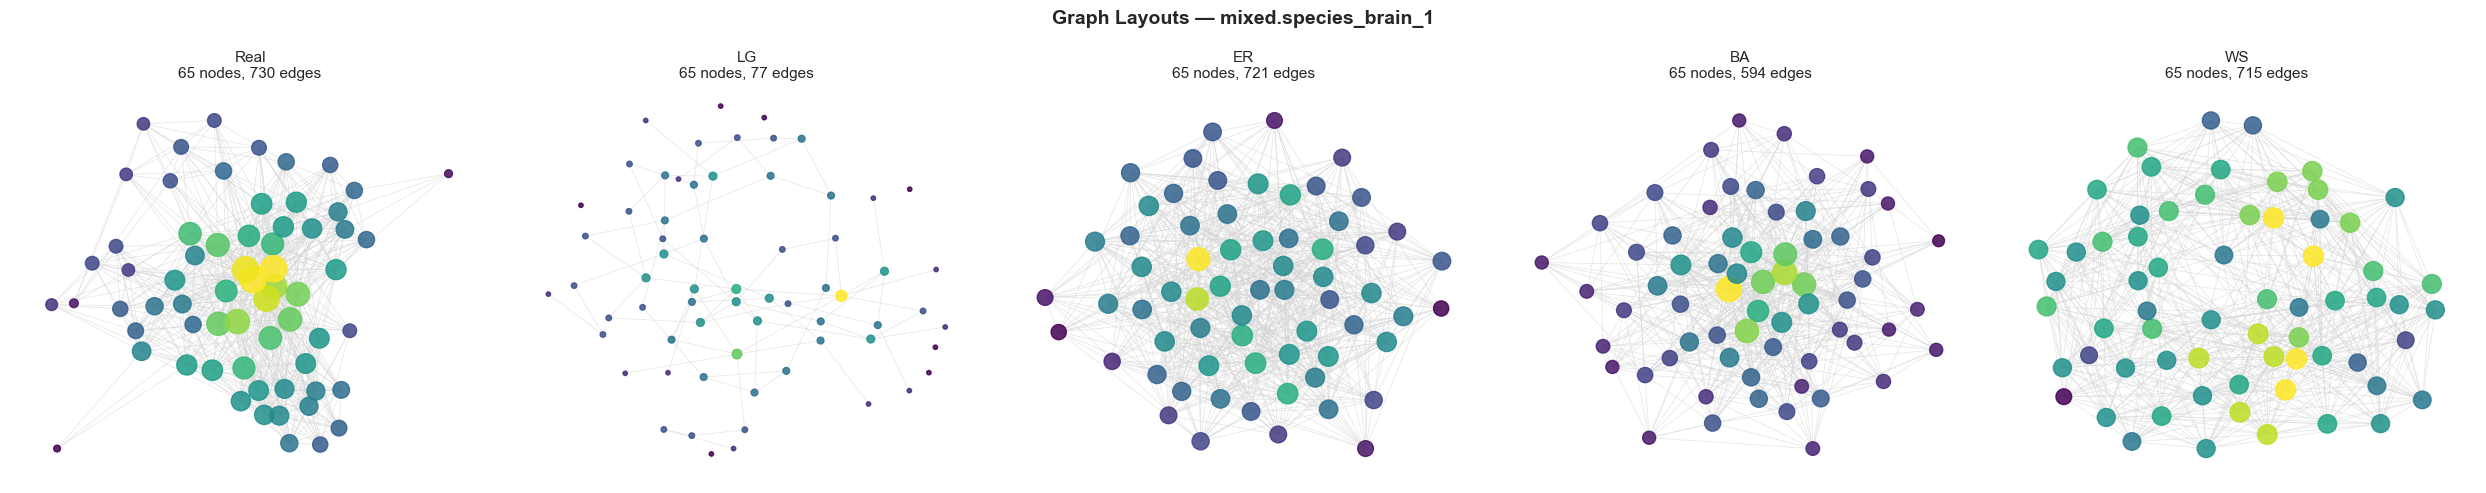

In [20]:
models = {
    'Real': G_ref,
    'LG': G_lg,
    'ER': G_er,
    'BA': G_ba,
    'WS': G_ws,
}
colors = {'Real': 'coral', 'LG': 'steelblue', 'ER': 'seagreen', 'BA': 'darkorange', 'WS': 'mediumpurple'}

# ---- Row 1: Graph layouts ----
fig, axes = plt.subplots(1, len(models), figsize=(5 * len(models), 5))

for ax, (name, G) in zip(axes, models.items()):
    pos = nx.spring_layout(G, seed=42, k=0.5, iterations=50)
    deg = dict(G.degree())
    node_sizes = [max(10, d * 8) for d in deg.values()]
    node_colors = list(deg.values())
    nx.draw_networkx_edges(G, pos, ax=ax, edge_color='lightgray', alpha=0.6, width=0.5)
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=node_sizes, node_color=node_colors,
                           cmap=plt.cm.viridis, alpha=0.85)
    ax.set_title(f'{name}\n{G.number_of_nodes()} nodes, {G.number_of_edges()} edges', fontsize=11)
    ax.axis('off')

plt.suptitle('Graph Layouts — mixed.species_brain_1', fontsize=14, fontweight='bold')
plt.tight_layout(); plt.show()

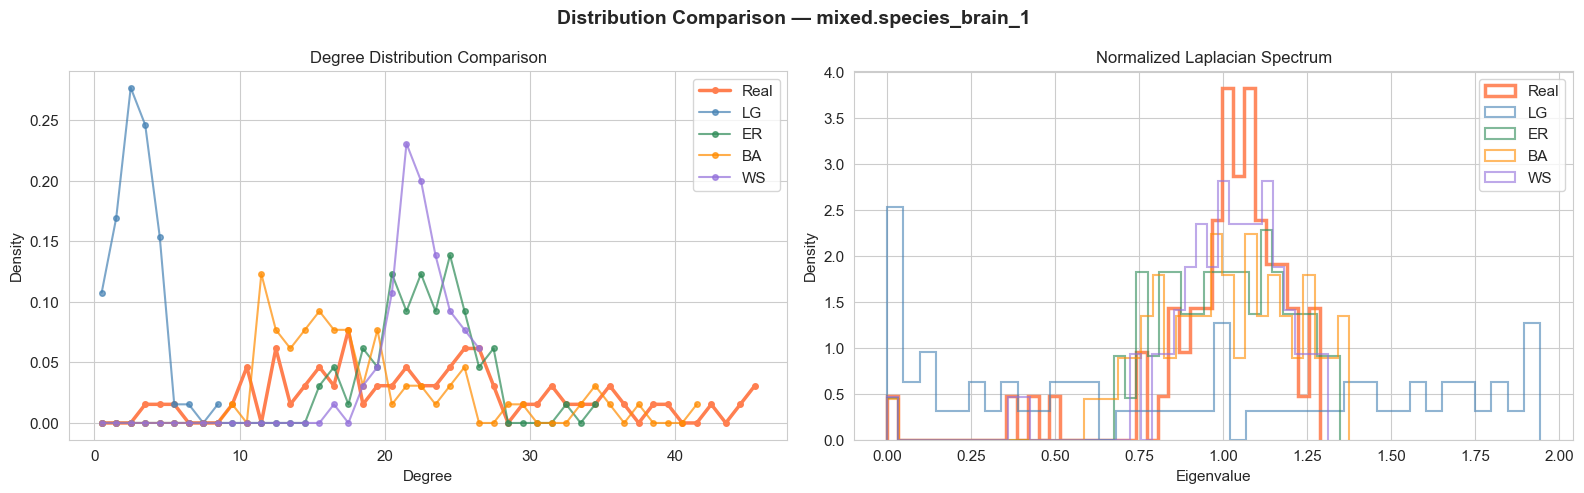

In [21]:
# ---- Row 2: Degree distributions + Spectrum overlays ----
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Degree distributions
for name, G in models.items():
    degs = sorted([d for _, d in G.degree()])
    lw = 2.5 if name == 'Real' else 1.5
    alpha = 1.0 if name == 'Real' else 0.7
    counts, bin_edges = np.histogram(degs, bins=range(0, max(degs)+2), density=True)
    centres = (bin_edges[:-1] + bin_edges[1:]) / 2
    axes[0].plot(centres, counts, 'o-', color=colors[name], label=name, linewidth=lw, alpha=alpha, markersize=4)
axes[0].set_xlabel('Degree', fontsize=11); axes[0].set_ylabel('Density', fontsize=11)
axes[0].set_title('Degree Distribution Comparison', fontsize=12)
axes[0].legend()

# Normalized Laplacian spectrum
for name, G in models.items():
    spec = np.linalg.eigvalsh(nx.normalized_laplacian_matrix(G).todense())
    lw = 2.5 if name == 'Real' else 1.5
    alpha = 0.9 if name == 'Real' else 0.6
    axes[1].hist(spec, bins=40, density=True, alpha=alpha, color=colors[name],
                 label=name, histtype='step', linewidth=lw)
axes[1].set_xlabel('Eigenvalue', fontsize=11); axes[1].set_ylabel('Density', fontsize=11)
axes[1].set_title('Normalized Laplacian Spectrum', fontsize=12)
axes[1].legend()

plt.suptitle('Distribution Comparison — mixed.species_brain_1', fontsize=14, fontweight='bold')
plt.tight_layout(); plt.show()

### 12b. Quantitative comparison — GIC, KS distance, clustering error

In [22]:
comparison_rows = []
ref_degrees = sorted([d for _, d in G_ref.degree()])
ref_clustering = nx.average_clustering(G_ref)
ref_density = nx.density(G_ref)

for name, G in models.items():
    if name == 'Real':
        continue
    # GIC (spectral distance)
    gic_val = GraphInformationCriterion(G_ref, model='LG', log_graph=G, dist='KL').calculate_gic()
    
    # KS test on degree distribution
    gen_degrees = sorted([d for _, d in G.degree()])
    ks_stat, ks_p = ks_2samp(ref_degrees, gen_degrees)
    
    # Absolute errors
    clust_err = abs(nx.average_clustering(G) - ref_clustering)
    density_err = abs(nx.density(G) - ref_density)
    edge_err = abs(G.number_of_edges() - m_ref)
    
    comparison_rows.append({
        'Model': name,
        'Edges': G.number_of_edges(),
        'Edge Error': edge_err,
        'Density Error': f'{density_err:.4f}',
        'GIC (KL)': f'{gic_val:.4f}',
        'KS Stat': f'{ks_stat:.4f}',
        'KS p-value': f'{ks_p:.4f}',
        'Clustering Error': f'{clust_err:.4f}',
    })

df_compare = pd.DataFrame(comparison_rows)
print(f'Reference: {n_ref} nodes, {m_ref} edges, density={ref_density:.4f}, clustering={ref_clustering:.4f}')
print()
df_compare

Reference: 65 nodes, 730 edges, density=0.3510, clustering=0.6614



,Model,Edges,Edge Error,Density Error,GIC (KL),KS Stat,KS p-value,Clustering Error
0,LG,77,653,0.3139,5.6549,0.9538,0.0000,0.6373
1,ER,721,9,0.0043,1.1685,0.2769,0.0133,0.3158
2,BA,594,136,0.0654,1.2567,0.2923,0.0075,0.2927
3,WS,715,15,0.0072,0.3671,0.3538,0.0005,0.1820


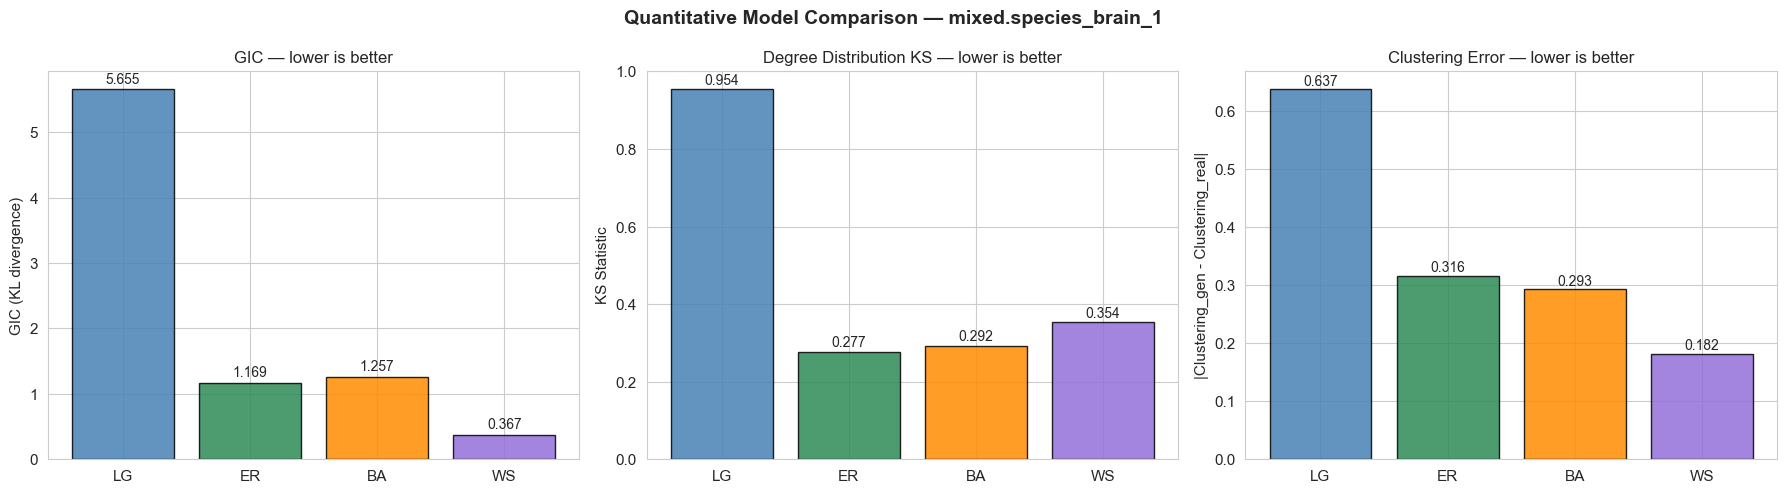

In [23]:
# Bar chart of GIC values
gic_vals = {row['Model']: float(row['GIC (KL)']) for row in comparison_rows}
ks_vals = {row['Model']: float(row['KS Stat']) for row in comparison_rows}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# GIC
bars = axes[0].bar(gic_vals.keys(), gic_vals.values(),
                    color=[colors[m] for m in gic_vals.keys()], alpha=0.85, edgecolor='black')
axes[0].set_ylabel('GIC (KL divergence)', fontsize=11)
axes[0].set_title('GIC — lower is better', fontsize=12)
for bar, v in zip(bars, gic_vals.values()):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                 f'{v:.3f}', ha='center', va='bottom', fontsize=10)

# KS statistic
bars = axes[1].bar(ks_vals.keys(), ks_vals.values(),
                    color=[colors[m] for m in ks_vals.keys()], alpha=0.85, edgecolor='black')
axes[1].set_ylabel('KS Statistic', fontsize=11)
axes[1].set_title('Degree Distribution KS — lower is better', fontsize=12)
for bar, v in zip(bars, ks_vals.values()):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                 f'{v:.3f}', ha='center', va='bottom', fontsize=10)

# Clustering error
clust_vals = {row['Model']: float(row['Clustering Error']) for row in comparison_rows}
bars = axes[2].bar(clust_vals.keys(), clust_vals.values(),
                    color=[colors[m] for m in clust_vals.keys()], alpha=0.85, edgecolor='black')
axes[2].set_ylabel('|Clustering_gen - Clustering_real|', fontsize=11)
axes[2].set_title('Clustering Error — lower is better', fontsize=12)
for bar, v in zip(bars, clust_vals.values()):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
                 f'{v:.3f}', ha='center', va='bottom', fontsize=10)

plt.suptitle('Quantitative Model Comparison — mixed.species_brain_1', fontsize=14, fontweight='bold')
plt.tight_layout(); plt.show()

---
## 13. Interactive baseline comparison

Adjust the LG parameters and see how it compares to ER, BA, WS in real time.

In [24]:
output2 = widgets.Output()

# Precompute baselines (they don't change with LG params)
baselines = {
    'ER': G_er,
    'BA': G_ba,
    'WS': G_ws,
}
baseline_gic = {name: GraphInformationCriterion(G_ref, model='LG', log_graph=G, dist='KL').calculate_gic()
                for name, G in baselines.items()}

def interactive_comparison(sigma, beta, d, n_iter):
    with output2:
        clear_output(wait=True)
        
        G_lg_live, _ = run_sim(n_ref, d=d, sigma=sigma, beta=beta, n_iter=n_iter, seed=42)
        if G_lg_live is None or G_lg_live.number_of_edges() == 0:
            print('LG generated empty graph — adjust parameters.')
            return
        
        all_models = {'Real': G_ref, 'LG': G_lg_live, **baselines}
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 11))
        
        # 1) Degree distributions
        for name, G in all_models.items():
            degs = sorted([d for _, d in G.degree()])
            lw = 2.5 if name == 'Real' else 1.5
            counts, be = np.histogram(degs, bins=range(0, max(degs)+2), density=True)
            centres = (be[:-1] + be[1:]) / 2
            axes[0, 0].plot(centres, counts, 'o-', color=colors[name], label=name,
                            linewidth=lw, markersize=4, alpha=0.8 if name != 'Real' else 1.0)
        axes[0, 0].set_xlabel('Degree'); axes[0, 0].set_ylabel('Density')
        axes[0, 0].set_title('Degree Distribution'); axes[0, 0].legend()
        
        # 2) Spectrum
        for name, G in all_models.items():
            spec = np.linalg.eigvalsh(nx.normalized_laplacian_matrix(G).todense())
            lw = 2.5 if name == 'Real' else 1.5
            axes[0, 1].hist(spec, bins=40, density=True, alpha=0.7 if name != 'Real' else 0.9,
                            color=colors[name], label=name, histtype='step', linewidth=lw)
        axes[0, 1].set_xlabel('Eigenvalue'); axes[0, 1].set_ylabel('Density')
        axes[0, 1].set_title('Normalized Laplacian Spectrum'); axes[0, 1].legend()
        
        # 3) GIC bar chart
        lg_gic = GraphInformationCriterion(G_ref, model='LG', log_graph=G_lg_live, dist='KL').calculate_gic()
        all_gic = {'LG': lg_gic, **baseline_gic}
        bar_colors = [colors[m] for m in all_gic.keys()]
        bars = axes[1, 0].bar(all_gic.keys(), all_gic.values(), color=bar_colors, alpha=0.85, edgecolor='black')
        for bar, v in zip(bars, all_gic.values()):
            axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.03,
                            f'{v:.3f}', ha='center', va='bottom', fontsize=10)
        axes[1, 0].set_ylabel('GIC (KL)'); axes[1, 0].set_title('GIC — lower is better')
        
        # 4) Summary table as text
        axes[1, 1].axis('off')
        table_data = []
        for name, G in all_models.items():
            st = graph_stats(G)
            table_data.append([name, G.number_of_edges(), f'{st["density"]:.3f}',
                               f'{st["avg_degree"]:.1f}', f'{st["avg_clustering"]:.3f}',
                               st['max_degree']])
        table = axes[1, 1].table(
            cellText=table_data,
            colLabels=['Model', 'Edges', 'Density', 'Avg Deg', 'Clustering', 'Max Deg'],
            loc='center', cellLoc='center',
        )
        table.auto_set_font_size(False); table.set_fontsize(10)
        table.scale(1, 1.8)
        # Color header and model column
        for (row, col), cell in table.get_celld().items():
            if row == 0:
                cell.set_facecolor('#333333'); cell.set_text_props(color='white', fontweight='bold')
            elif col == 0:
                model_name = table_data[row - 1][0]
                cell.set_facecolor(colors.get(model_name, 'white'))
                cell.set_alpha(0.3)
        axes[1, 1].set_title('Summary Statistics', fontsize=12, pad=20)
        
        plt.suptitle(f'LG(sigma={sigma:.2f}, beta={beta:.4f}, d={d}) vs baselines',
                     fontsize=14, fontweight='bold')
        plt.tight_layout(); plt.show()

sigma2 = widgets.FloatSlider(value=sigma_lg, min=-10.0, max=2.0, step=0.5,
                              description='sigma:', style={'description_width': '60px'})
beta2 = widgets.FloatSlider(value=beta_lg, min=-0.1, max=0.2, step=0.005,
                             description='beta:', readout_format='.4f',
                             style={'description_width': '60px'})
d2 = widgets.IntSlider(value=1, min=0, max=3, description='d:',
                        style={'description_width': '60px'})
iter2 = widgets.IntSlider(value=3000, min=500, max=10000, step=500,
                           description='iterations:', style={'description_width': '80px'})

ui2 = widgets.VBox([widgets.HBox([sigma2, beta2, d2, iter2])])

interactive2 = widgets.interactive_output(
    interactive_comparison,
    {'sigma': sigma2, 'beta': beta2, 'd': d2, 'n_iter': iter2}
)

display(ui2, output2)
# Trigger initial render
interactive_comparison(sigma2.value, beta2.value, d2.value, iter2.value)

Output()